 Module 1: Adjective/Verb Analysis

In [115]:
# Imports & Setup
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re

# Seaborn style
sns.set(style="whitegrid")
plt.rcParams["figure.dpi"] = 120
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["axes.titlesize"] = 14

# Path to wikipedia-data folder
base_path = r"D:\PROG\docu3C\BollyAI_2_0\Data\wikipedia-data"

In [116]:
def load_verb_file(filepath):
    years = []
    verbs = []
    with open(filepath, "r", encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split(",", 1)
            if len(parts) == 2:
                year = parts[0].strip()
                verb_raw = parts[1].strip()
                verb_clean = re.findall(r'\w+', verb_raw)  # extract words from [verbs...]
                years.append(int(year))
                verbs.append(verb_clean)
    return pd.DataFrame({"year": years, "verbs": verbs})

male_verb = load_verb_file(os.path.join(base_path, "male_verb.csv"))
female_verb = load_verb_file(os.path.join(base_path, "female_verb.csv"))

# Remove rows with no verbs
male_verb = male_verb[male_verb["verbs"].map(len) > 0]
female_verb = female_verb[female_verb["verbs"].map(len) > 0]


In [117]:
def plot_top_verbs_facet(df, gender="male", top_n=6):
    from matplotlib.ticker import MaxNLocator
    verb_freq_by_year = {}

    for _, row in df.iterrows():
        year = row["year"]
        for verb in row["verbs"]:
            key = (year, verb)
            verb_freq_by_year[key] = verb_freq_by_year.get(key, 0) + 1

    df_verbs = pd.DataFrame([
        {"year": y, "verb": v, "count": c}
        for (y, v), c in verb_freq_by_year.items()
    ])
    
    if df_verbs.empty:
        print(f"⚠️ No verbs found for {gender}")
        return

    top_verbs = df_verbs.groupby("verb")["count"].sum().nlargest(top_n).index
    df_top = df_verbs[df_verbs["verb"].isin(top_verbs)]

    g = sns.FacetGrid(df_top, col="verb", col_wrap=3, height=4, sharey=False)
    g.map_dataframe(sns.lineplot, x="year", y="count", marker="o", color="indigo")
    g.set_titles(col_template="{col_name}")
    g.set_axis_labels("Year", "Frequency")
    for ax in g.axes.flatten():
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax.tick_params(axis='x', rotation=45)
    plt.suptitle(f"📈 Top {top_n} Verbs Used by {gender.capitalize()} Characters Over Time", fontsize=16, y=1.05)
    plt.tight_layout()
    plt.show()


In [118]:
print("Cleaned Sample Male Verbs:\n", male_verb.head(10))
print("Cleaned Sample Female Verbs:\n", female_verb.head(10))


Cleaned Sample Male Verbs:
     year                                  verbs
0   1970                            [convinces]
2   1970                                [lives]
3   1970                                [lives]
6   1970              [offers, proposes, loves]
8   1970                                 [gets]
12  1970  [leaves, proposes, survives, appears]
14  1970                [plans, comes, informs]
16  1970                                 [nets]
17  1970                               [thinks]
20  1970             [challenges, loses, wants]
Cleaned Sample Female Verbs:
     year                                              verbs
0   1970                                       [introduces]
1   1970                                          [decides]
2   1970                                            [moves]
3   1970                                     [finds, stops]
4   1970                                     [comes, takes]
5   1970                                            [p

C:\Users\Aldrin Joan\AppData\Local\Temp\ipykernel_39124\1716724083.py:31: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
d:\Softwares\Anaconda3\envs\biasai\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


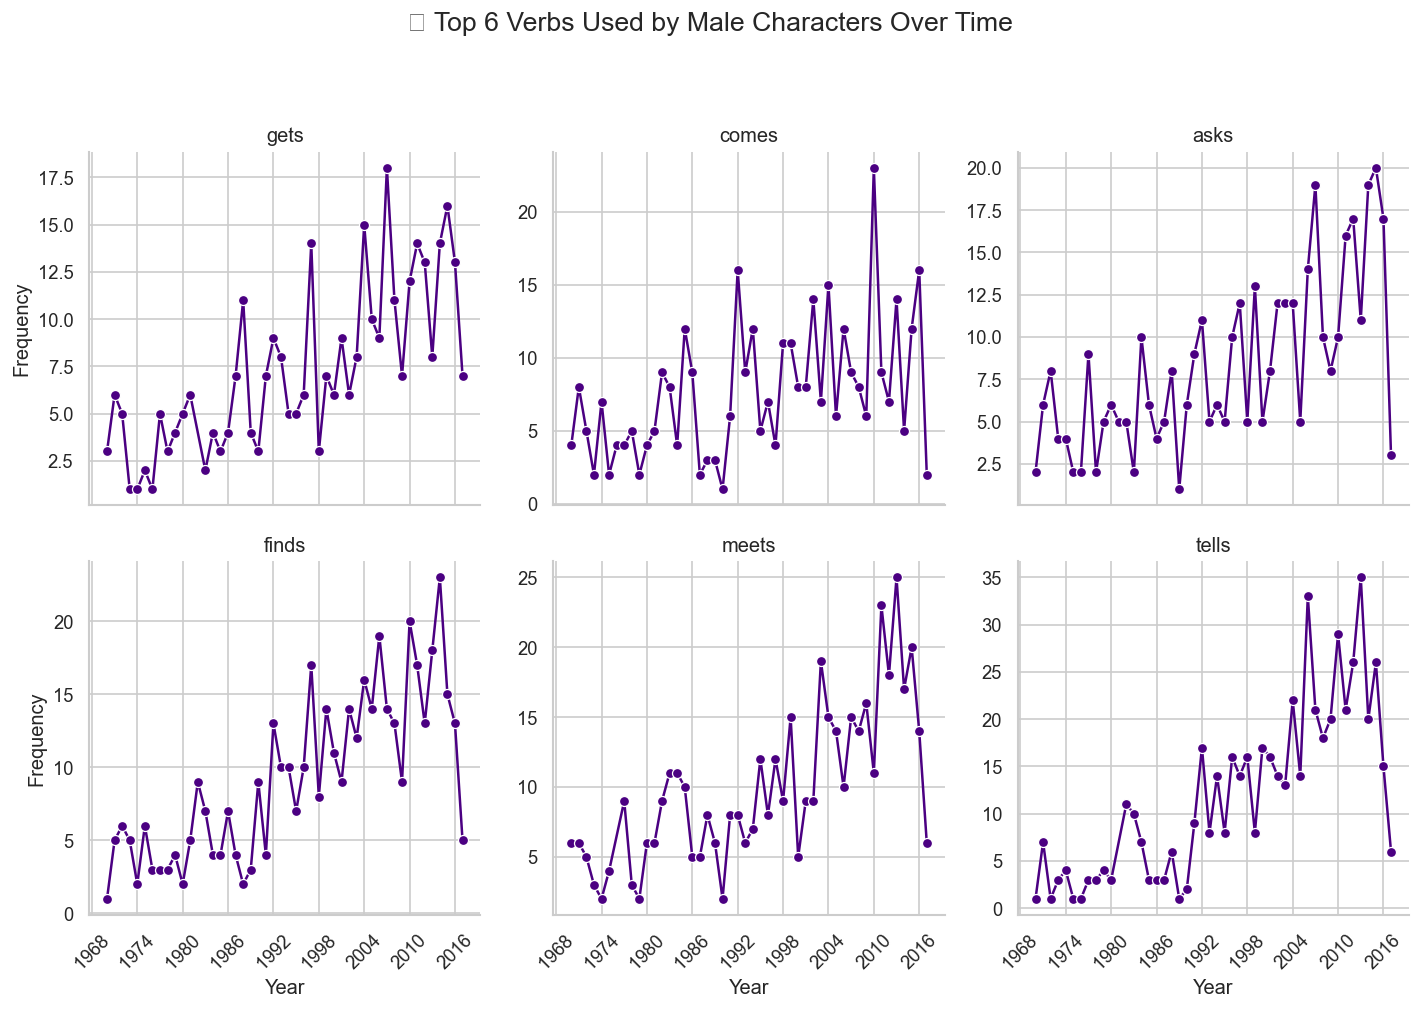

C:\Users\Aldrin Joan\AppData\Local\Temp\ipykernel_39124\1716724083.py:31: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
d:\Softwares\Anaconda3\envs\biasai\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


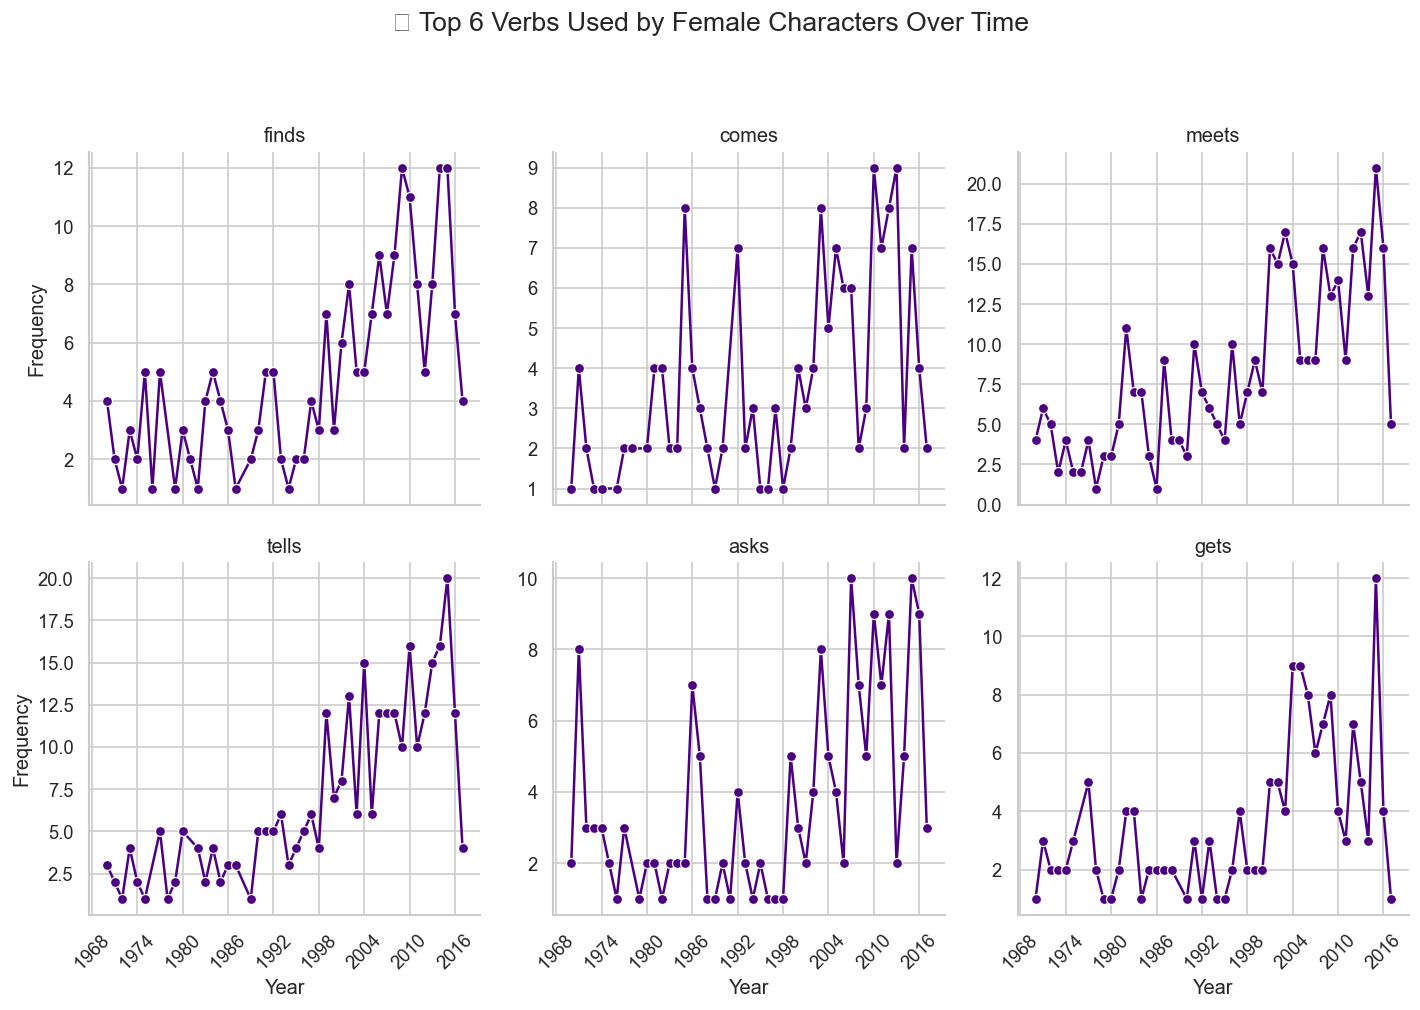

In [119]:
plot_top_verbs_facet(male_verb, gender="male")
plot_top_verbs_facet(female_verb, gender="female")

Module 2: Centrality Metrics

In [120]:
# Cell 2.1 – Load & Clean Centrality Data
male_centrality = pd.read_csv(os.path.join(base_path, "male_centrality.csv"))
female_centrality = pd.read_csv(os.path.join(base_path, "female_centrality.csv"))

male_centrality["gender"] = "male"
female_centrality["gender"] = "female"

centrality = pd.concat([male_centrality, female_centrality], ignore_index=True)

# Clean column names (strip whitespace + remove duplicates manually if any)
centrality.columns = centrality.columns.str.strip()
centrality = centrality.loc[:, ~centrality.columns.duplicated()]

🎯 Average Centrality by Gender:
gender
female    4.96
male      4.81
Name: Average Centrality, dtype: float64


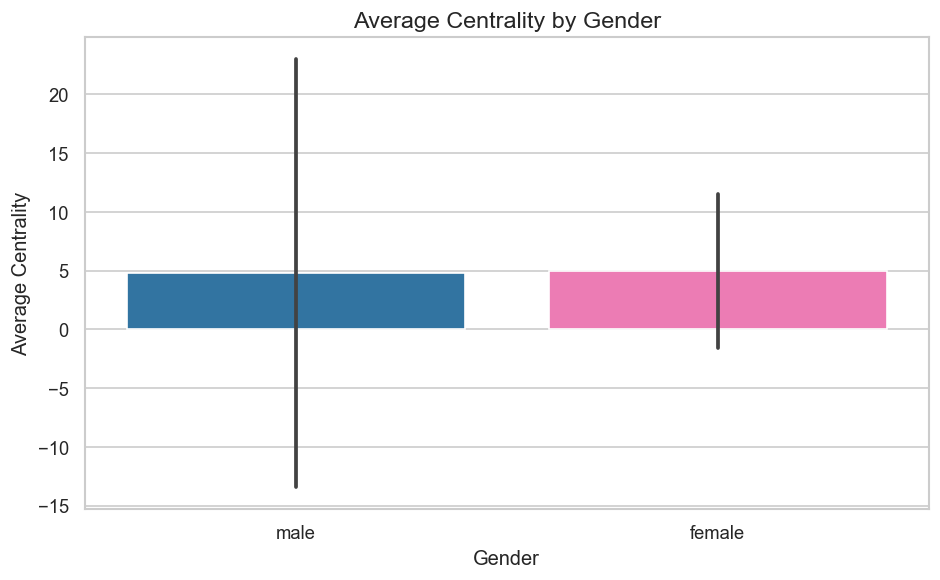

In [121]:
# Cell 2.2
# Print numerical values
print("🎯 Average Centrality by Gender:")
print(centrality.groupby("gender")["Average Centrality"].mean().round(2))
plt.figure(figsize=(8, 5))
sns.barplot(
    data=centrality,
    x="gender",
    y="Average Centrality",
    hue="gender",              
    palette={"male": "#1f77b4", "female": "#ff69b4"},
    errorbar="sd",
    legend=False 
)

plt.title("Average Centrality by Gender", fontsize=14)
plt.ylabel("Average Centrality")
plt.xlabel("Gender")
plt.tight_layout()
plt.show()

Module 3: Coreference Plots

In [122]:
coref = pd.read_csv(os.path.join(base_path, "coref_plot.csv"), usecols=["Movie Name", "Coref Plot"])
coref.columns = coref.columns.str.strip()
all_words = " ".join(coref["Coref Plot"].astype(str).str.lower()).split()
male_pronouns = ["he", "him", "his"]
female_pronouns = ["she", "her", "hers"]
pronouns_to_track = male_pronouns + female_pronouns
pronoun_counts = Counter(word for word in all_words if word in pronouns_to_track)
pronoun_df = pd.DataFrame(pronoun_counts.items(), columns=["pronoun", "count"]).sort_values("count", ascending=False)

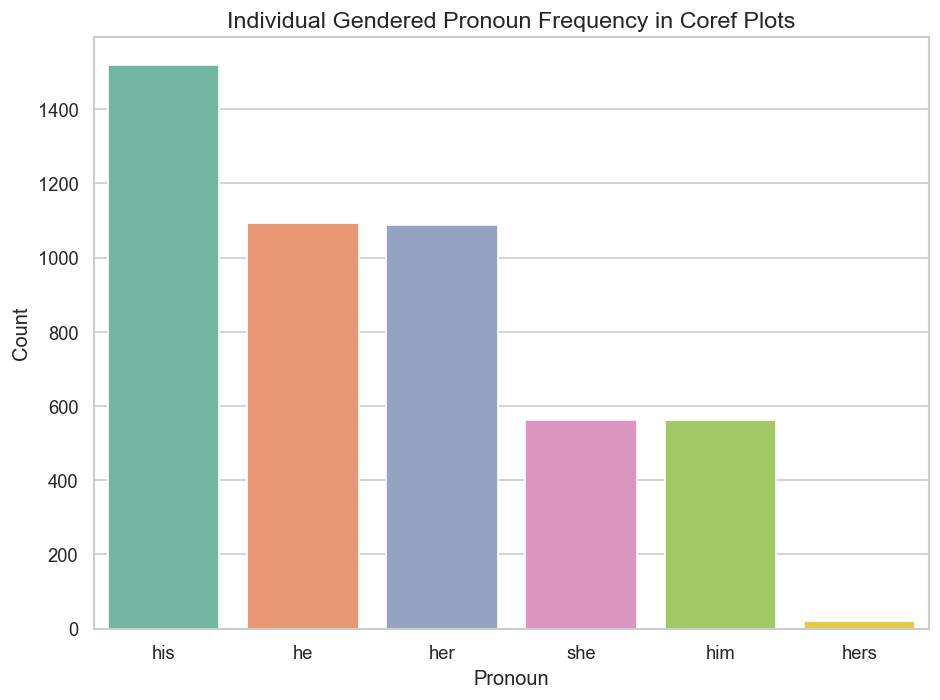

Individual Pronoun Counts:
  she: 562
  her: 1088
  his: 1518
  him: 562
  he: 1094
  hers: 19


In [123]:
# Cell 3.2 - Plot 1: Individual Pronoun Frequency
plt.figure(figsize=(8, 6))
sns.barplot(data=pronoun_df, x="pronoun", y="count", hue="pronoun", palette="Set2", legend=False)
plt.title("Individual Gendered Pronoun Frequency in Coref Plots")
plt.xlabel("Pronoun")
plt.ylabel("Count")
plt.tight_layout()
plt.show()
print("Individual Pronoun Counts:")
for pronoun, count in pronoun_counts.items():
    print(f"  {pronoun}: {count}")


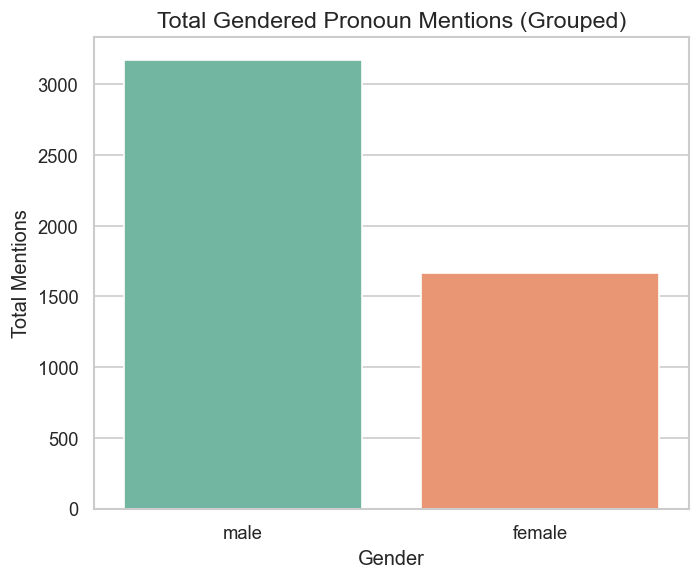


Grouped Gender Totals:
  Male pronouns (he/him/his): 3174
  Female pronouns (she/her/hers): 1669


In [124]:
# Cell 3.3 - Plot 2: Grouped Male vs Female Totals
male_total = sum(pronoun_counts[p] for p in male_pronouns)
female_total = sum(pronoun_counts[p] for p in female_pronouns)

gender_totals_df = pd.DataFrame({
    "gender": ["male", "female"],
    "count": [male_total, female_total]
})

plt.figure(figsize=(6, 5))
sns.barplot(data=gender_totals_df, x="gender", y="count", hue="gender", palette="Set2", legend=False)
plt.title("Total Gendered Pronoun Mentions (Grouped)")
plt.xlabel("Gender")
plt.ylabel("Total Mentions")
plt.tight_layout()
plt.show()
male_total = sum(pronoun_counts[p] for p in male_pronouns)
female_total = sum(pronoun_counts[p] for p in female_pronouns)

print("\nGrouped Gender Totals:")
print(f"  Male pronouns (he/him/his): {male_total}")
print(f"  Female pronouns (she/her/hers): {female_total}")

Module 4: Song Bias

In [125]:
# Cell 4.1 – Load & Preprocess Songs Data (Robust Fix)
songs_db = pd.read_csv(
    os.path.join(base_path, "songsDB.csv"),
    on_bad_lines="skip",
    encoding="utf-8"
)
songs_freq = pd.read_csv(os.path.join(base_path, "songsFrequency.csv"))
songs_db.columns = songs_db.columns.str.strip().str.lower()
songs_freq.columns = songs_freq.columns.str.strip().str.upper()
print("🔍 songs_db.columns =", songs_db.columns.tolist())
title_col = [col for col in songs_db.columns if "title" in col and "year" in col]
if title_col:
    title_col = title_col[0]
    songs_db["year"] = songs_db[title_col].str.extract(r"_(\d{4})")[0]
    songs_db = songs_db.dropna(subset=["year"])
    songs_db["year"] = songs_db["year"].astype(int)
else:
    raise ValueError("❌ Could not find column with movie title and year")
if "gender" in songs_db.columns and "song_count" in songs_db.columns:
    songs_gender_year = (
        songs_db.groupby(["year", "gender"])["song_count"]
        .sum()
        .reset_index()
    )
    songs_gender_year["gender"] = songs_gender_year["gender"].str.strip().str.lower()
else:
    raise ValueError("❌ Required columns 'gender' or 'song_count' not found in songsDB")
melted_songs_freq = pd.melt(
    songs_freq,
    id_vars=["YEAR"],
    value_vars=["MALE SONG COUNT", "FEMALE SONG COUNT"],
    var_name="gender",
    value_name="count"
)
melted_songs_freq["gender"] = melted_songs_freq["gender"].str.replace(" SONG COUNT", "").str.lower()

🔍 songs_db.columns = ['movietitle_year', 'singer_name', 'gender', 'song_count']


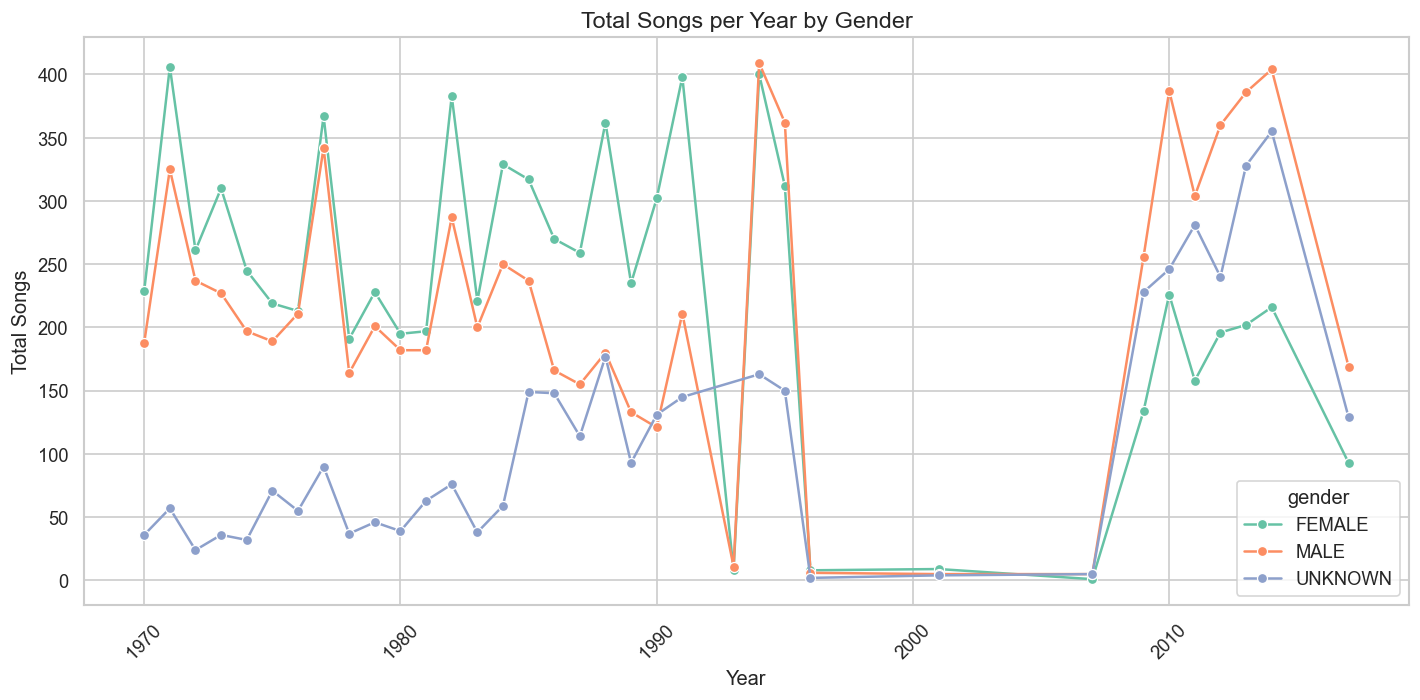

In [126]:
# Cell 4.2 – Total songs per gender per year
song_counts = (
    songs_db.groupby(["year", "gender"])["song_count"]
    .sum()
    .reset_index()
)

plt.figure(figsize=(12, 6))
sns.lineplot(data=song_counts, x="year", y="song_count", hue="gender", marker="o", palette="Set2")
plt.title("Total Songs per Year by Gender")
plt.xlabel("Year")
plt.ylabel("Total Songs")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


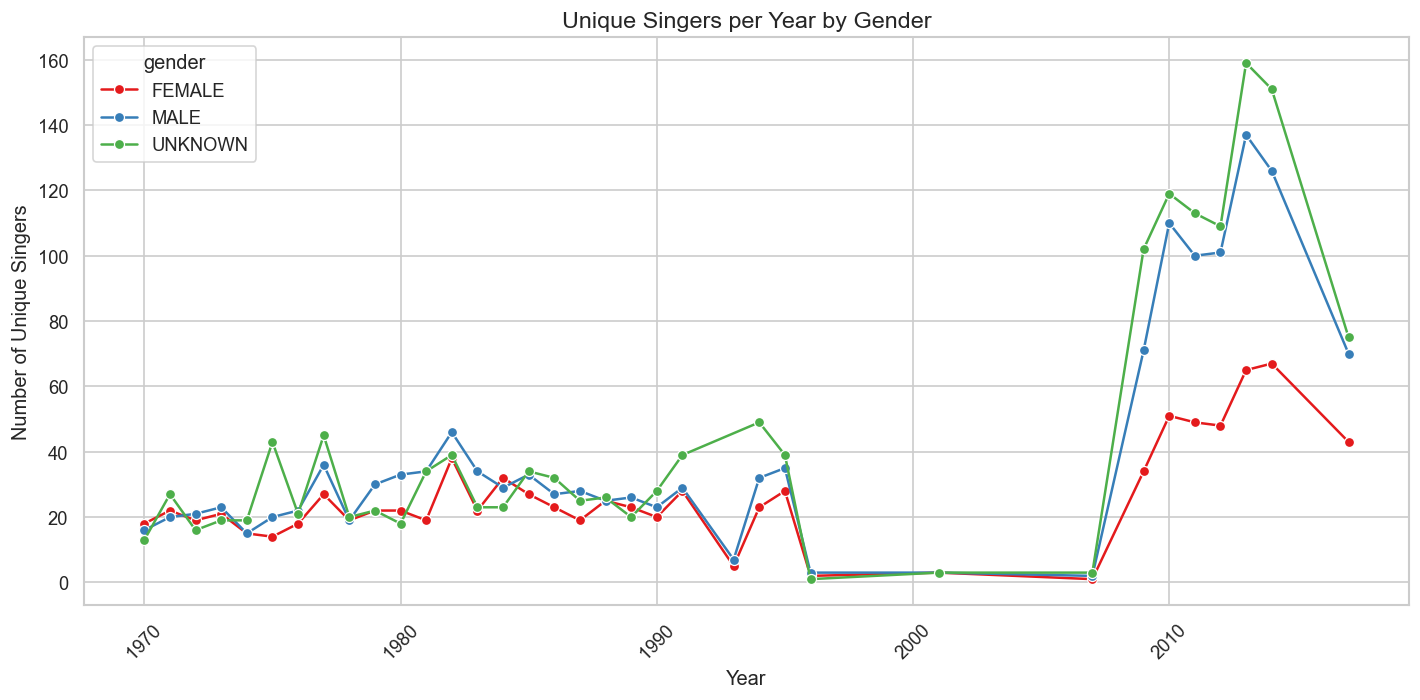

In [127]:
# Cell 4.3 – Unique singers per year by gender
unique_singers = (
    songs_db.groupby(["year", "gender"])["singer_name"]
    .nunique()
    .reset_index(name="unique_singers")
)

plt.figure(figsize=(12, 6))
sns.lineplot(data=unique_singers, x="year", y="unique_singers", hue="gender", marker="o", palette="Set1")
plt.title("Unique Singers per Year by Gender")
plt.xlabel("Year")
plt.ylabel("Number of Unique Singers")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


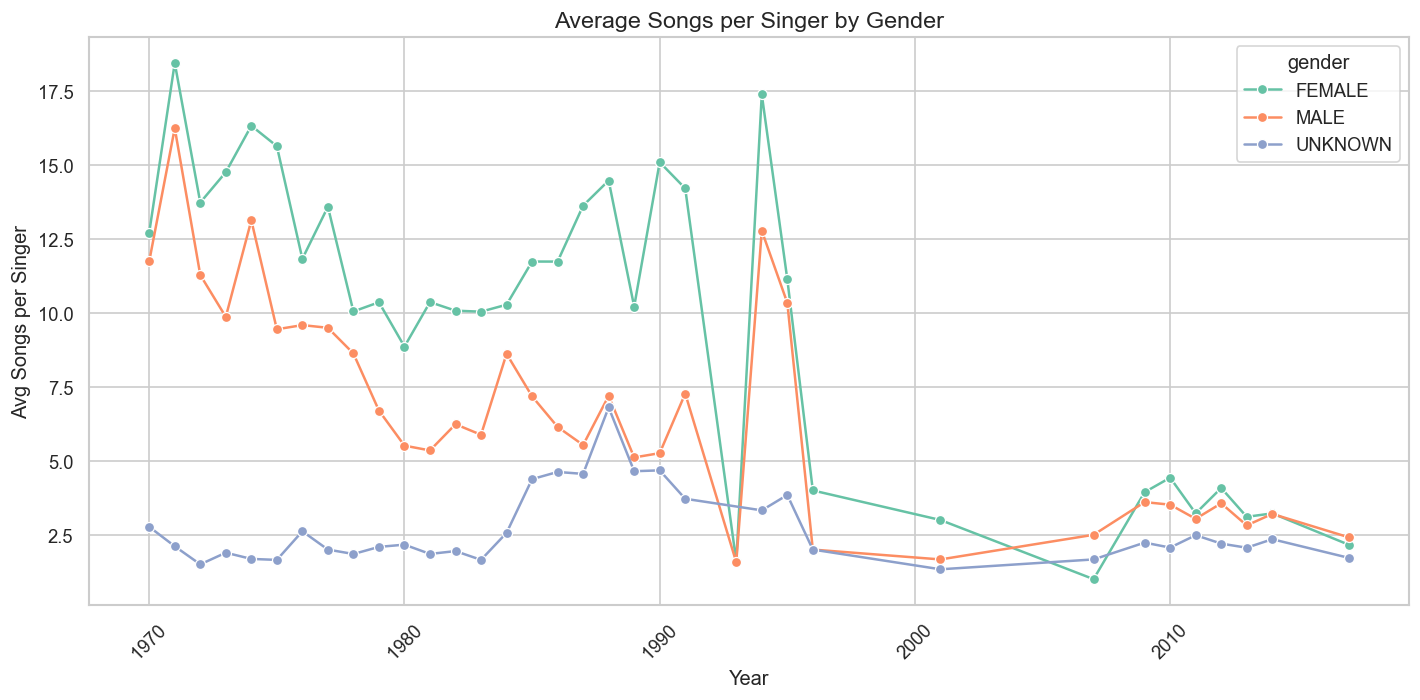

In [128]:
# Cell 4.4 – Average songs per singer by gender per year
songs_per_singer = (
    songs_db.groupby(["year", "gender"])
    .agg(total_songs=("song_count", "sum"), total_singers=("singer_name", "nunique"))
    .reset_index()
)

songs_per_singer["avg_songs_per_singer"] = songs_per_singer["total_songs"] / songs_per_singer["total_singers"]

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=songs_per_singer, 
    x="year", y="avg_songs_per_singer", 
    hue="gender", marker="o", palette="Set2"
)
plt.title("Average Songs per Singer by Gender")
plt.xlabel("Year")
plt.ylabel("Avg Songs per Singer")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Module 5: Gender Representation Ratio

In [129]:
base_path = r"D:\PROG\docu3C\BollyAI_2_0\Data\wikipedia-data"
male_df = pd.read_csv(os.path.join(base_path, "male_mentions_centrality.csv"))
female_df = pd.read_csv(os.path.join(base_path, "female_mentions_centrality.csv"))


In [130]:
male_df.columns = female_df.columns = [c.strip().lower().replace(" ", "_") for c in male_df.columns]
male_grouped = male_df.groupby("movie_name").agg({
    "mentions": "sum",
    "total_centrality": "sum",
    "average_centrality": "mean",
    "cast": "count"
}).rename(columns={
    "mentions": "male_mentions",
    "total_centrality": "male_total_centrality",
    "average_centrality": "male_avg_centrality",
    "cast": "male_cast_count"
})

female_grouped = female_df.groupby("movie_name").agg({
    "mentions": "sum",
    "total_centrality": "sum",
    "average_centrality": "mean",
    "cast": "count"
}).rename(columns={
    "mentions": "female_mentions",
    "total_centrality": "female_total_centrality",
    "average_centrality": "female_avg_centrality",
    "cast": "female_cast_count"
})

In [131]:
combined_df = pd.merge(male_grouped, female_grouped, on="movie_name", how="inner")
epsilon = 1e-6
combined_df["mentions_ratio"] = combined_df["male_mentions"] / (combined_df["female_mentions"] + epsilon)
combined_df["centrality_ratio"] = combined_df["male_total_centrality"] / (combined_df["female_total_centrality"] + epsilon)
combined_df["cast_ratio"] = combined_df["male_cast_count"] / (combined_df["female_cast_count"] + epsilon)
combined_df["avg_centrality_diff"] = combined_df["male_avg_centrality"] - combined_df["female_avg_centrality"]

In [133]:
output_path = os.path.join(base_path, "D:\PROG\docu3C\BollyAI_2_0\output\gender_bias_comparison.csv")
combined_df.to_csv(output_path, index=True)
print(f"✅ Saved comparison CSV to: {output_path}")

✅ Saved comparison CSV to: D:\PROG\docu3C\BollyAI_2_0\output\gender_bias_comparison.csv


<>:1: SyntaxWarning: invalid escape sequence '\P'
<>:1: SyntaxWarning: invalid escape sequence '\P'
C:\Users\Aldrin Joan\AppData\Local\Temp\ipykernel_39124\2206514499.py:1: SyntaxWarning: invalid escape sequence '\P'
  output_path = os.path.join(base_path, "D:\PROG\docu3C\BollyAI_2_0\output\gender_bias_comparison.csv")
